In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
REPO_NAME = 'sewer-nfl'
import sys, os
cwd = str(os.getcwd())
repo_dir = cwd[:cwd.find(REPO_NAME)+len(REPO_NAME)]
sys.path.insert(0,repo_dir)

In [3]:
from models.pe1.pipeline import model_df, pbp_api_data

2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [4]:
import numpy as np
import pandas as pd
final_model_data = pbp_api_data[['game_id','season','week','home_team','away_team','home_score',
                                 'away_score']]\
    .drop_duplicates().merge(
        model_df,
        how = 'left'
    )
final_model_data['home_cover'] = final_model_data.apply(lambda x: 1 if x['home_score'] - \
                                                                  x['away_score'] < \
                                                                  x['spread_line'] else 0,
                                                         axis = 1)
final_model_data = final_model_data.apply(pd.to_numeric, errors='coerce', axis=1)


LABEL = 'home_cover'
PREDICTORS = [
    'spread_line',
    'def_elo_QB_pass_x', 'off_elo_QB_pass_x', 'def_elo_RB_rec_x',
    'def_elo_TE_rec_x', 'def_elo_WR_rec_x', 'off_elo_RB_rec_x',
    'off_elo_TE_rec_x', 'off_elo_WR_rec_x', 'def_elo_QB_rush_x',
    'def_elo_RB_rush_x', 
    'off_elo_QB_rush_x', 'off_elo_RB_rush_x', 
    'def_elo_QB_pass_y',
    'off_elo_QB_pass_y', 'def_elo_RB_rec_y', 'def_elo_TE_rec_y',
    'def_elo_WR_rec_y', 'off_elo_RB_rec_y', 'off_elo_TE_rec_y',
    'off_elo_WR_rec_y', 'def_elo_QB_rush_y', 'def_elo_RB_rush_y',
    'off_elo_QB_rush_y',
    'off_elo_RB_rush_y'
]

In [61]:
X, y = final_model_data[PREDICTORS], final_model_data[[LABEL]]

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())]
)
num_cols = X.select_dtypes(include="number").columns

In [63]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols)
    ]
)

In [64]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier()

In [65]:
# Note, do train test split first
train_mask = final_model_data['season']!=2022
X_tr = X[train_mask]
X_te = X[~train_mask]
y_train = y[train_mask]
y_test = np.array(y[~train_mask])

In [66]:
# Apply preprocessing
X_train = full_processor.fit_transform(X_tr)
X_test = full_processor.fit_transform(X_te)

In [67]:
# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=False)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=False)

In [12]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
xgb_cl = xgb.XGBClassifier(objective = 'binary:logistic')

grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")
_ = grid_cv.fit(X_train, y_train)
grid_cv.best_score_

0.5346850614457465

In [14]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'reg_lambda': 0,
 'scale_pos_weight': 5,
 'subsample': 0.8}

In [15]:
final_cl = xgb.XGBClassifier(
    objective="binary:logistic"
    )

from sklearn.metrics import roc_auc_score

final_cl.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test,y_test)],
    eval_metric='auc', 
    verbose = True
    )

preds = final_cl.predict(X_test)

[0]	validation_0-auc:0.49640
[1]	validation_0-auc:0.48158
[2]	validation_0-auc:0.47599
[3]	validation_0-auc:0.47864
[4]	validation_0-auc:0.48981
[5]	validation_0-auc:0.46588
[6]	validation_0-auc:0.45302
[7]	validation_0-auc:0.45414
[8]	validation_0-auc:0.45765
[9]	validation_0-auc:0.45574
[10]	validation_0-auc:0.45269
[11]	validation_0-auc:0.45782
[12]	validation_0-auc:0.46179
[13]	validation_0-auc:0.45133
[14]	validation_0-auc:0.46060
[15]	validation_0-auc:0.46517
[16]	validation_0-auc:0.47128
[17]	validation_0-auc:0.46632
[18]	validation_0-auc:0.46114
[19]	validation_0-auc:0.47101
[20]	validation_0-auc:0.47509
[21]	validation_0-auc:0.47684
[22]	validation_0-auc:0.46877
[23]	validation_0-auc:0.46806
[24]	validation_0-auc:0.46986
[25]	validation_0-auc:0.47825
[26]	validation_0-auc:0.47204
[27]	validation_0-auc:0.46746
[28]	validation_0-auc:0.47782
[29]	validation_0-auc:0.48071
[30]	validation_0-auc:0.47885
[31]	validation_0-auc:0.48518
[32]	validation_0-auc:0.49101
[33]	validation_0-au

c:\Users\zacha\Documents\GitHub\sewer-nfl\.venv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[52]	validation_0-auc:0.50218
[53]	validation_0-auc:0.50131
[54]	validation_0-auc:0.50273
[55]	validation_0-auc:0.50382
[56]	validation_0-auc:0.50921
[57]	validation_0-auc:0.51030
[58]	validation_0-auc:0.51041
[59]	validation_0-auc:0.51025
[60]	validation_0-auc:0.50992
[61]	validation_0-auc:0.51619
[62]	validation_0-auc:0.51466
[63]	validation_0-auc:0.51766
[64]	validation_0-auc:0.52175
[65]	validation_0-auc:0.52251
[66]	validation_0-auc:0.52186
[67]	validation_0-auc:0.52049
[68]	validation_0-auc:0.52311
[69]	validation_0-auc:0.52142
[70]	validation_0-auc:0.52256
[71]	validation_0-auc:0.52529
[72]	validation_0-auc:0.52142
[73]	validation_0-auc:0.52769
[74]	validation_0-auc:0.52496
[75]	validation_0-auc:0.52654
[76]	validation_0-auc:0.52507
[77]	validation_0-auc:0.52425
[78]	validation_0-auc:0.52518
[79]	validation_0-auc:0.52932
[80]	validation_0-auc:0.52943
[81]	validation_0-auc:0.52883
[82]	validation_0-auc:0.52829
[83]	validation_0-auc:0.52502
[84]	validation_0-auc:0.52327
[85]	valid

In [16]:
from sklearn.metrics import confusion_matrix
y_true = np.array([x[0] for x in y_test])
y_pred = preds
confusion_matrix(y_true, y_pred)

array([[76, 63],
       [59, 73]], dtype=int64)

In [17]:
accuracy_score(y_true,y_pred)

0.5498154981549815

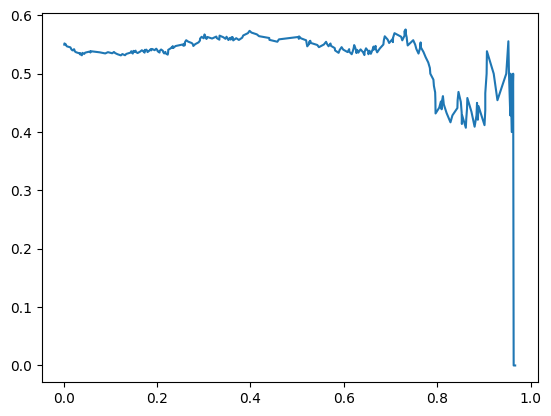

In [19]:

from matplotlib import pyplot as plt
pred_probs = final_cl.predict_proba(X_test)
conf = [0.5 - x[0] if x[0] < 0.5 else x[0] for x in pred_probs]
x = pd.DataFrame({
    'conf':conf,
    'pred':preds,
    'true':y_true
}).sort_values(['conf'],ascending=False)
x['correct'] = x.apply(lambda s : 1 if s['pred'] == s['true'] else 0, axis=1)

x['total_correct'] = x['correct'].cumsum()
n = np.array(range(len(x))) + 1
x['n'] = n
x['hr'] = x['total_correct'] / x['n']

plt.plot(x['conf'],x['hr'])

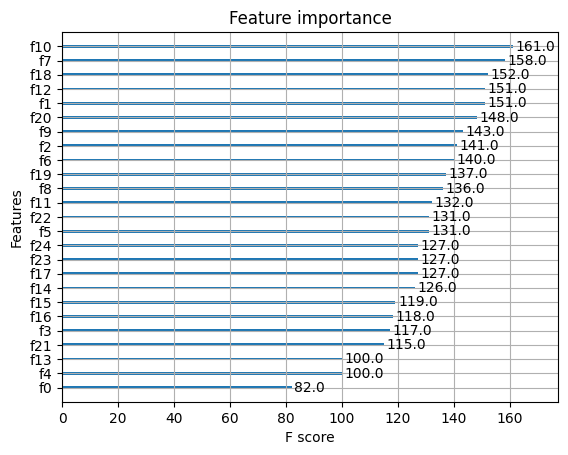

In [20]:
from xgboost import plot_importance

plot_importance(final_cl)
plt.show()

In [21]:
f_to_imp = {i:final_cl.feature_importances_[i] for i in range(len(final_cl.feature_importances_))}
s = sorted(f_to_imp.items(), key=lambda x:x[1], reverse=True)

top_n = 20

ids = [x[0] for x in list(s)[:top_n]]
list(map(PREDICTORS.__getitem__, ids))

['off_elo_TE_rec_x',
 'off_elo_QB_rush_x',
 'off_elo_WR_rec_y',
 'def_elo_RB_rush_y',
 'def_elo_QB_rush_y',
 'off_elo_QB_rush_y',
 'off_elo_RB_rec_x',
 'def_elo_WR_rec_x',
 'def_elo_TE_rec_y',
 'def_elo_WR_rec_y',
 'def_elo_QB_pass_x',
 'def_elo_RB_rec_y',
 'def_elo_QB_pass_y',
 'off_elo_RB_rush_x',
 'def_elo_QB_rush_x',
 'def_elo_RB_rec_x',
 'off_elo_TE_rec_y',
 'def_elo_RB_rush_x',
 'spread_line',
 'off_elo_WR_rec_x']

# Other Model Approaches

### 1. Outputting distribution of possible spreads

In [22]:
final_model_data = pbp_api_data[['game_id','season','week','home_team','away_team','home_score',
                                 'away_score']]\
    .drop_duplicates().merge(
        model_df,
        how = 'left'
    )
final_model_data['home_cover'] = final_model_data.apply(lambda x: 1 if x['home_score'] - \
                                                                  x['away_score'] < \
                                                                  x['spread_line'] else 0,
                                                         axis = 1)

In [68]:
from lazypredict.Supervised import LazyRegressor, LazyClassifier
cls= LazyClassifier(ignore_warnings=False, custom_metric=None)
models, predictions = cls.fit(X_train, X_test, y_train, y_test)

 31%|███       | 9/29 [00:00<00:00, 25.82it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 90%|████████▉ | 26/29 [00:01<00:00, 15.67it/s]

StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 29/29 [00:01<00:00, 15.99it/s]


In [109]:
final_model_data[(final_model_data['week']==1) & (final_model_data['season']!=2010)]

,game_id,season,week,home_team,away_team,home_score,away_score,old_game_id,spread_line,posteam_x,...,def_elo_TE_rec_y,def_elo_WR_rec_y,off_elo_RB_rec_y,off_elo_TE_rec_y,off_elo_WR_rec_y,def_elo_QB_rush_y,def_elo_RB_rush_y,off_elo_QB_rush_y,off_elo_RB_rush_y,home_cover
260,2011_01_ATL_CHI,2011,1,CHI,ATL,30,12,2011091105,-1.00,CHI,...,1948.15,1945.74,2004.72,2043.07,2016.14,1949.26,1982.74,1976.08,2008.27,0
261,2011_01_BUF_KC,2011,1,KC,BUF,7,41,2011091104,3.50,KC,...,1916.98,1896.97,1976.23,1992.16,1988.56,1996.34,2013.53,1989.83,1986.51,1
262,2011_01_CAR_ARI,2011,1,ARI,CAR,28,21,2011091109,6.50,ARI,...,1993.92,2027.84,1993.06,2008.11,1977.14,1965.33,2042.50,2000.00,1952.55,0
263,2011_01_CIN_CLE,2011,1,CLE,CIN,17,27,2011091101,6.50,CLE,...,1982.45,2049.55,1998.39,1967.21,2011.55,NaN,2045.85,NaN,2030.90,1
264,2011_01_DAL_NYJ,2011,1,NYJ,DAL,27,24,2011091112,6.50,NYJ,...,1989.15,2008.80,2001.38,2045.48,2009.99,1970.71,1898.00,2018.70,2000.12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,2022_01_NYG_TEN,2022,1,TEN,NYG,20,21,2022091108,5.50,TEN,...,1956.59,1974.50,1986.34,1981.40,2000.28,1940.91,2018.69,2001.21,1969.46,1
3146,2022_01_PHI_DET,2022,1,DET,PHI,35,38,2022091104,-6.00,DET,...,2128.50,2073.91,1977.62,2058.30,2015.86,1957.98,2115.40,2094.31,2025.70,0
3147,2022_01_PIT_CIN,2022,1,CIN,PIT,20,23,2022091103,7.50,CIN,...,2034.93,1996.58,1987.78,2007.46,1999.58,1979.78,2042.33,2007.90,1988.52,1
3148,2022_01_SF_CHI,2022,1,CHI,SF,19,10,2022091102,-6.50,CHI,...,1976.92,1986.74,2011.09,2004.47,2046.36,1974.25,2046.92,1984.88,1966.21,0


In [73]:
from sklearn.linear_model import PassiveAggressiveClassifier
clf = PassiveAggressiveClassifier(max_iter=1000, random_state=0,
                                  tol=1e-3)
clf.fit(X_train, y_train)

PassiveAggressiveClassifier(random_state=0)

In [102]:
x = clf.predict(X_test)
y = [y[0] for y in y_test]
res = [1 if x[i]==y[i] else 0 for i in range(len(x))]
sum(res) / len(res)

0.47601476014760147